# Google Colab Configuration


In [2]:
from IPython.core.display import display, HTML
# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))
import sys
import pandas as pd
import numpy as np
import operator
import string
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# Introduction


Nowadays, many companies use **Applicant Tracking Systems (ATS)** to manage the large number of applications they receive. These systems scan CVs for specific keywords and phrases that match the job description. If a CV does not contain these keywords, it might be filtered out even if the candidate is well-qualified.
The main objective of this project is to create a more fair model that can understand the context of the CV and relate it to a specific job position. This model would be more sophisticated and fairer because it would:

- **Analyze Context**: Go beyond simple keyword matching to understand the overall context of a candidate’s experience and skills.
- **Recognize Synonyms and Variations**: Identify relevant qualifications even if different terminology is used.
- **Assess Quality of Experience**: Evaluate the depth and relevance of a candidate's experience, not just the presence of specific terms.
- **Reduce Bias**: Mitigate the risk of overlooking qualified candidates who might be filtered out by traditional ATS due to a lack of exact keyword matches.

The project is based on a text classification problem, aiming to predict whether a given curriculum is best suited for a Python Developer, Network Administrator, or another role. The dataset we have at our disposal includes 28K curriculums.

We will use **Transfer Learning**. By leveraging a pre-trained model, we can take advantage of the vast amounts of data and training that have already been invested in BERT, and then fine-tune it specifically for our text classification task. This should significantly improve our model's performance and efficiency compared to training a model from scratch. Our process will involve the following steps:

- Step 1: **Exploratory Data Analysis**: to check some insights.
- Step 2: Use a pre-trained English Language Model (**Bert**) trained over a large dataset as starting point and adapt it to our domainb (**Fine-tuning**)
- Step 3: Create a **Machine Learning Classifier** on top of the dataset language model


# STEP 1: Exploratory Data Analysis

We will first read and inspect the dataset.

The dataset is provided and saved as "df". It has two columns: "label" and "Resume". "label" variable has 10 different unique categories.

In [3]:
import pandas as pd
import csv

def clean_csv(input_file_path, cleaned_file_path):
    cleaned_lines = []
    current_line = ""

    with open(input_file_path, 'r', newline='', encoding='utf-8') as file:
        for line in file:
            # Add the current line to the accumulating line
            current_line += line
            # Check if the accumulated line has balanced quotes
            if current_line.count('"') % 2 == 0:
                cleaned_lines.append(current_line)
                current_line = ""  # Reset for the next line
            else:
                # If not balanced, continue to accumulate lines
                continue

    # Write the cleaned lines to a new CSV file
    with open(cleaned_file_path, 'w', newline='', encoding='utf-8') as file:
        file.writelines(cleaned_lines)
input_file_path = '/dataset.csv'
cleaned_file_path = '/cleaned_dataset.csv'

clean_csv(input_file_path, cleaned_file_path)
df = pd.read_csv(cleaned_file_path)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Label,Resume
0,Web_Developer,Web Developer & System Administrator Web Devel...
1,Python_Developer,"Python Developer <span class=""hl"">Python</span..."
2,Systems_Administrator,"Systems Administrator <span class=""hl"">Systems..."
3,Security_Analyst,Regional Field Technician Regional Field Techn...
4,Software_Developer,Application Developer Application <span class=...


In [4]:
print(f'The shape of our database is: {df.shape}')

The shape of our database is: (29035, 2)


The possible categories that each curriculum can have are the following:

In [5]:
df['Label'].unique()

array(['Web_Developer', 'Python_Developer', 'Systems_Administrator',
       'Security_Analyst', 'Software_Developer', 'Network_Administrator',
       'Java_Developer', 'Project_manager', 'Database_Administrator'],
      dtype=object)

## Data Visualization

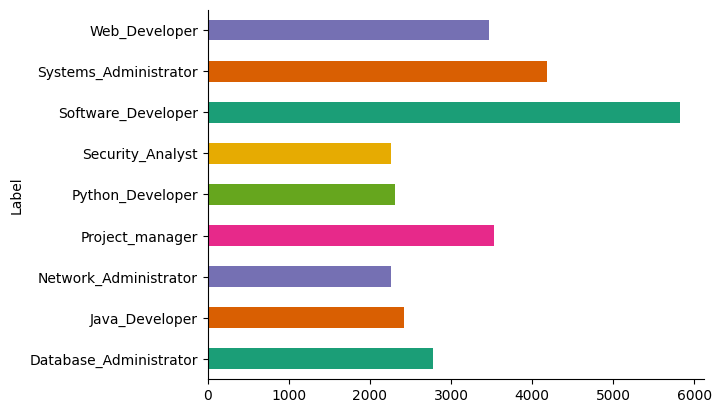

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
training_df, test_df1 = train_test_split(df, test_size=0.2, random_state=42)
test_df1.head()
test_df=test_df1.drop(['Label'],axis=1)
test_df.head()

,Resume
12463,Data Engineer Data Engineer Data Engineer - T....
4744,"IT Security Analyst <span class=""hl"">IT</span>..."
23339,Sr. Angularjs / Full Stack Developer Sr. Angul...
12465,"Network Support Technician <span class=""hl"">Ne..."
14649,Passengers Services Assistant Passengers Servi...


As you can see, the training set contains the dependent variable (the job role assigned) and the resume (text data). The test set contains the same independent variable, but no label whatsoever. As usual, We will use the training set to create our models and then we have to use these models to predict over the test set

In [8]:
print(f'The shape of our training set will be: {training_df.shape}')

The shape of our training set will be: (23228, 2)


## Inspecting the data

In this step we will try to get some insights regarding our data like common keywords used in each category.
We will also check for imbalances in the dataset.

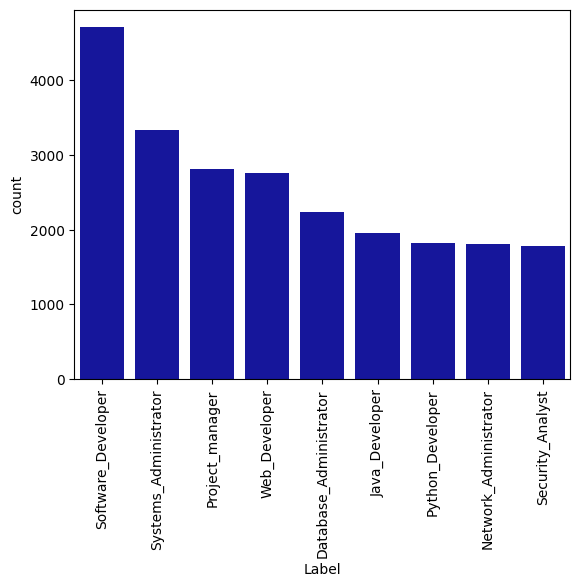

In [9]:
sorted_labels = [x for x, count in sorted(Counter(training_df['Label']).items(), key=lambda x: -x[1])]
sns.countplot(x=training_df['Label'], order=sorted_labels)
plt.xticks(rotation=90)
plt.show()

As you can see from the graph, our dataset has some differences in the distribution.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from matplotlib import interactive

def plot_most_common_features(text_col, target_col, n_features=50):
    """
    Plots the most common features in text data for each class.

    Parameters:
    - text_col: Series or list of text data
    - target_col: Series or list of target labels corresponding to the text data
    - n_features: Number of top features to plot for each class (default is 50)
    """
    df1 = pd.DataFrame({"Resume": text_col, "Label": target_col})

    grouped = df1.groupby(["Label"]).apply(lambda x: ' '.join(x["Resume"]))
    grouped_df1 = pd.DataFrame({"Label": grouped.index, "Resume": grouped.values})

    tokenizer = WhitespaceTokenizer()
    for ii, row in grouped_df1.iterrows():
        tokens = tokenizer.tokenize(row["Resume"])
        token_counts = pd.DataFrame(tokens, columns=["token"]).value_counts().head(n_features)
        token_counts.plot(kind="bar", cmap=plt.cm.seismic, figsize=(20, 5))
        plt.title(f"Most Common Features in Class: {row['Label']}", fontsize=20)
        plt.xticks(fontsize=15)
        plt.xlabel("Token", fontsize=15)
        plt.ylabel("Frequency", fontsize=15)
        plt.legend([])  # Remove the legend
        interactive(True)
        plt.show()


**In the pictures below the most common words within each class will be shown.**
As you can see, we haven't processed the data and there are no stopwords removed, so the results aren't very representative.

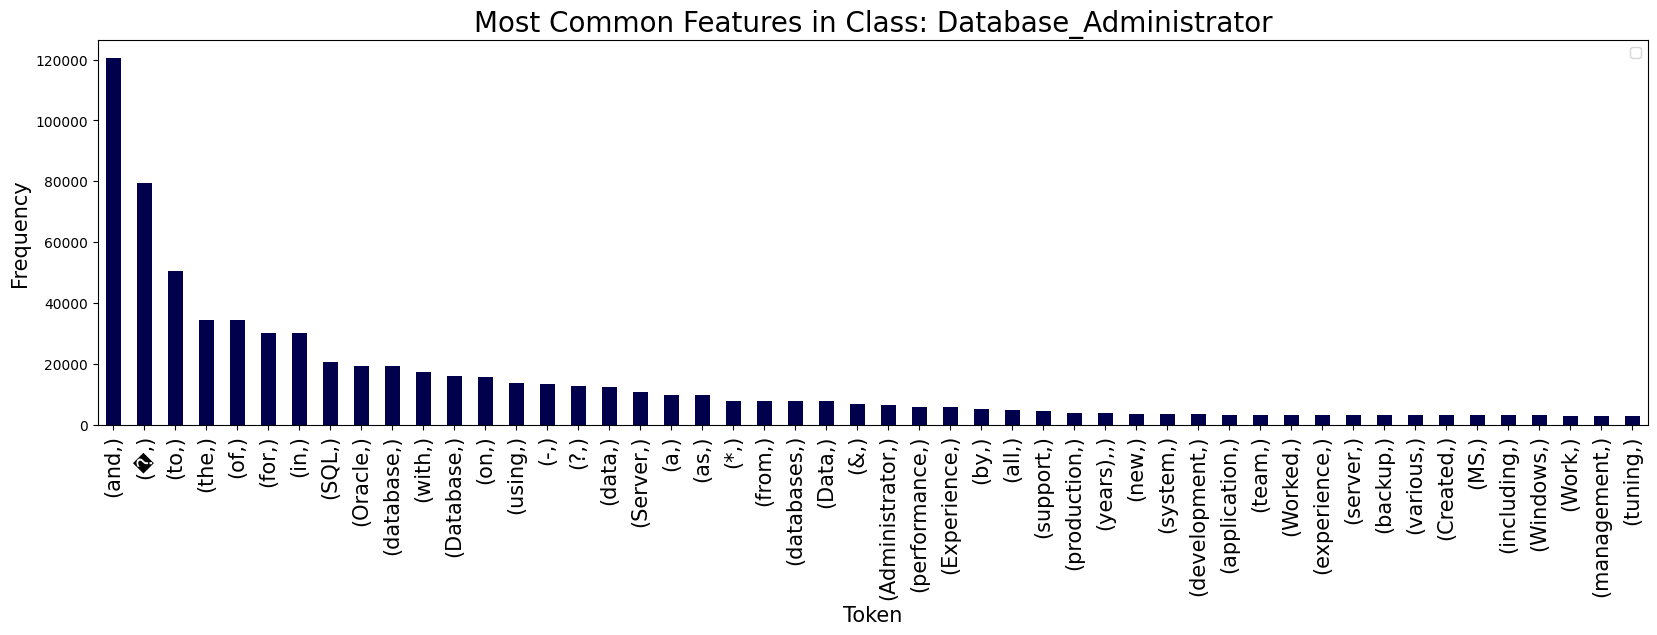

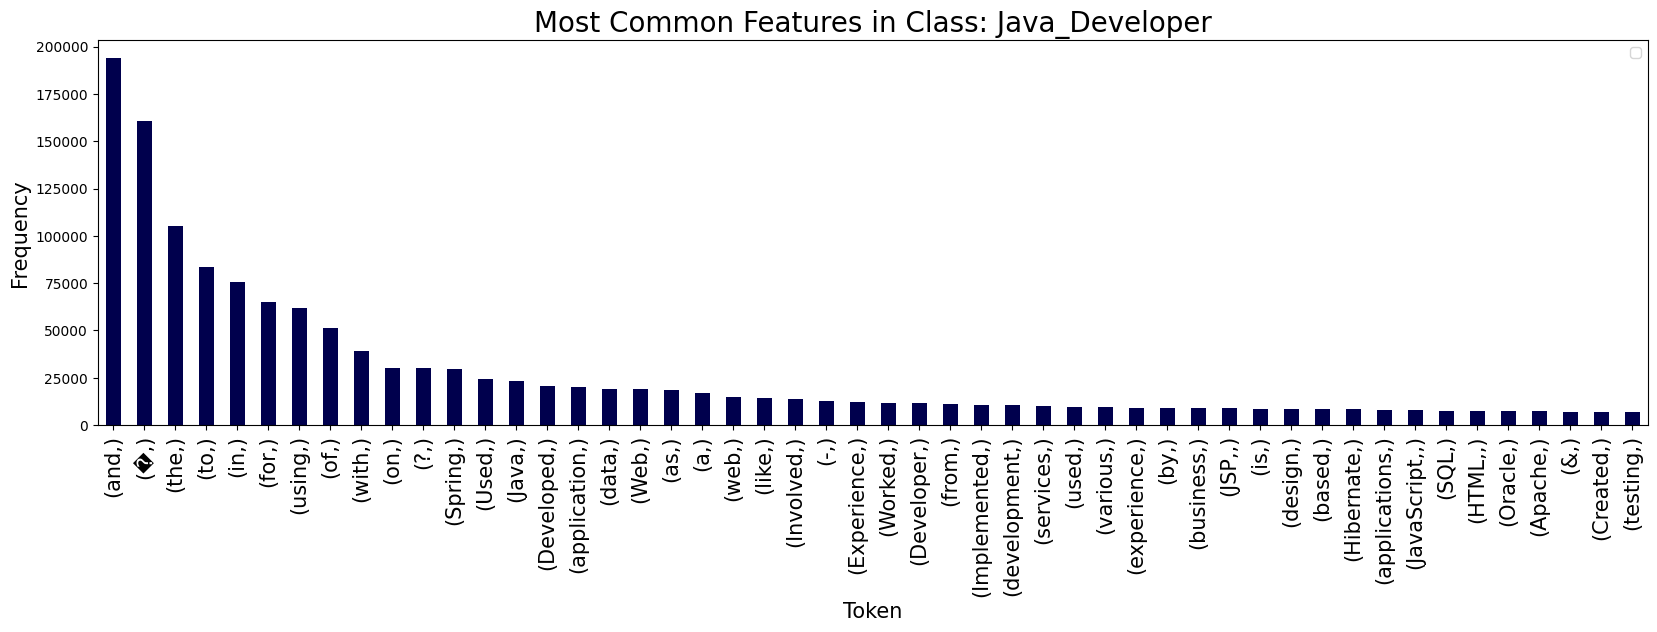

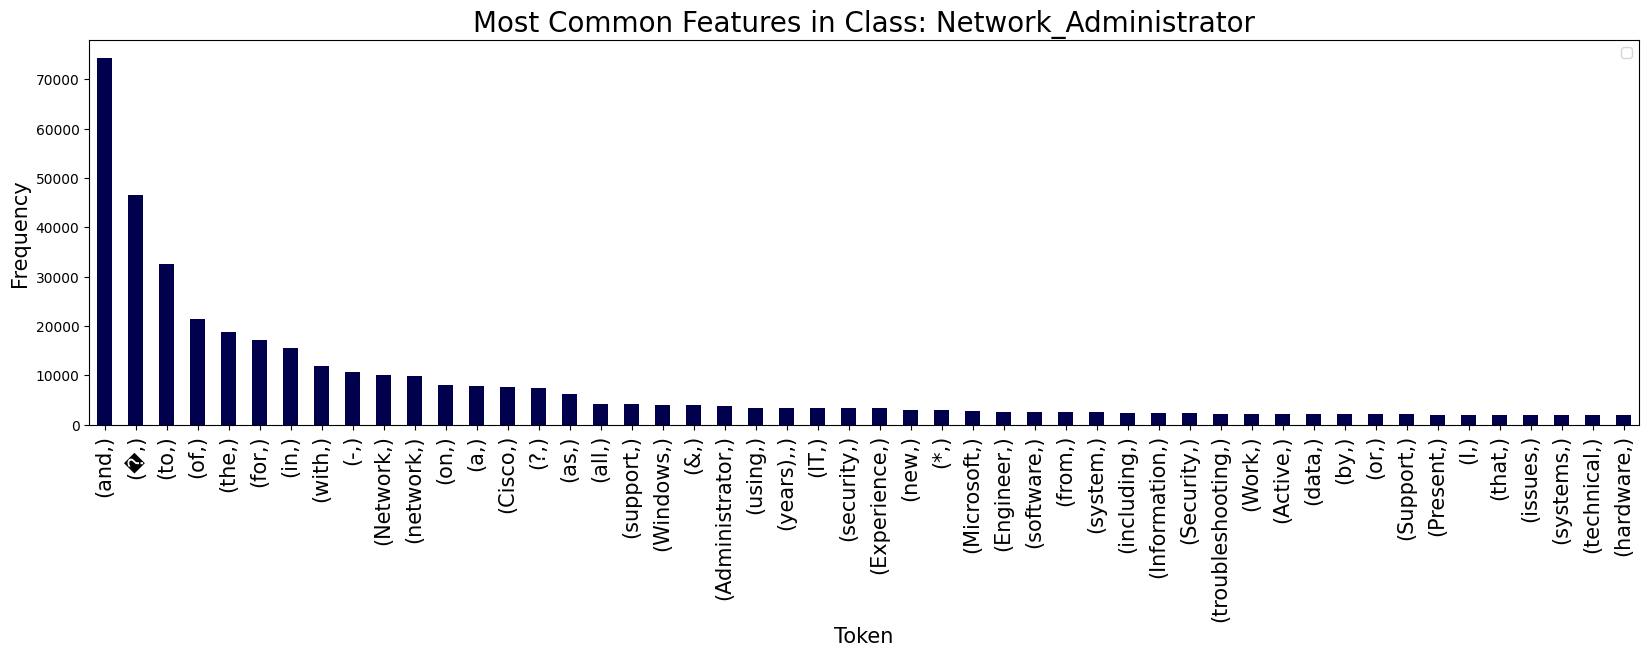

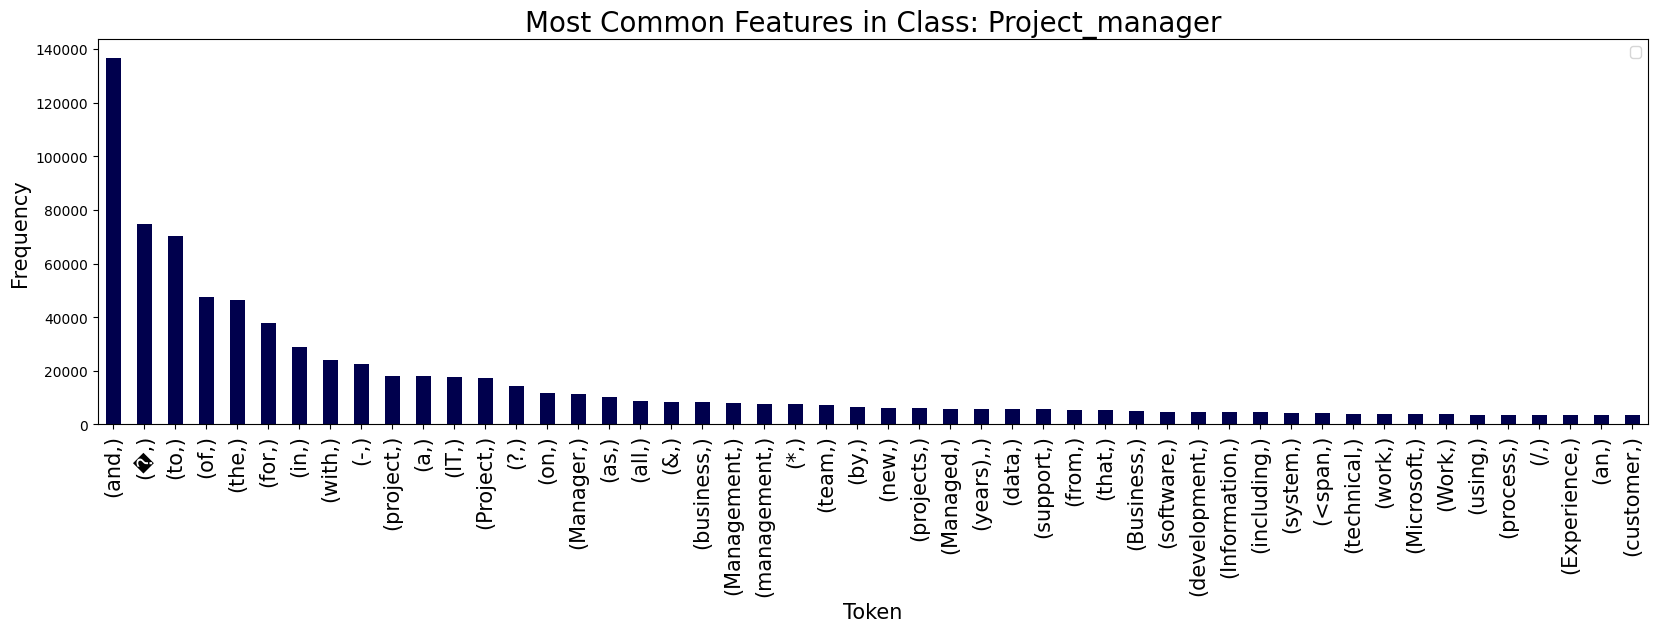

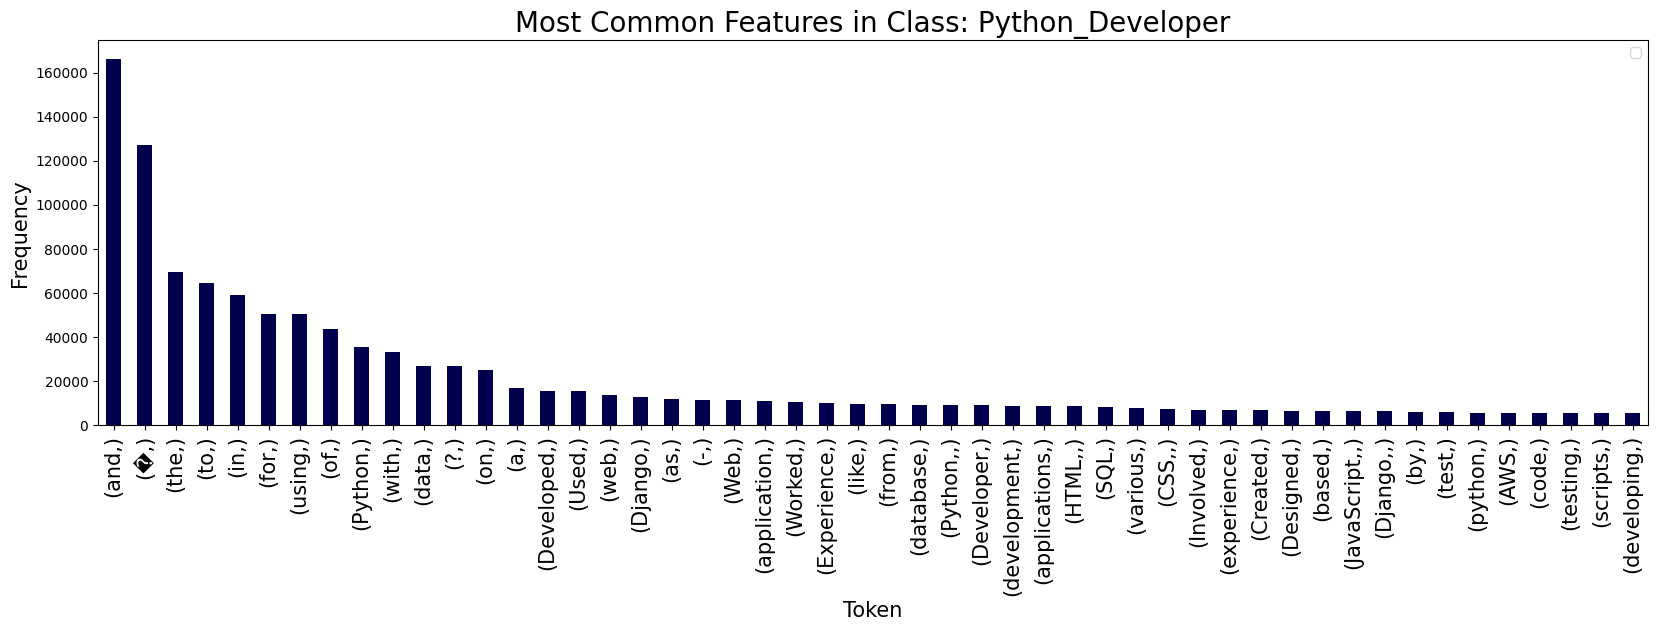

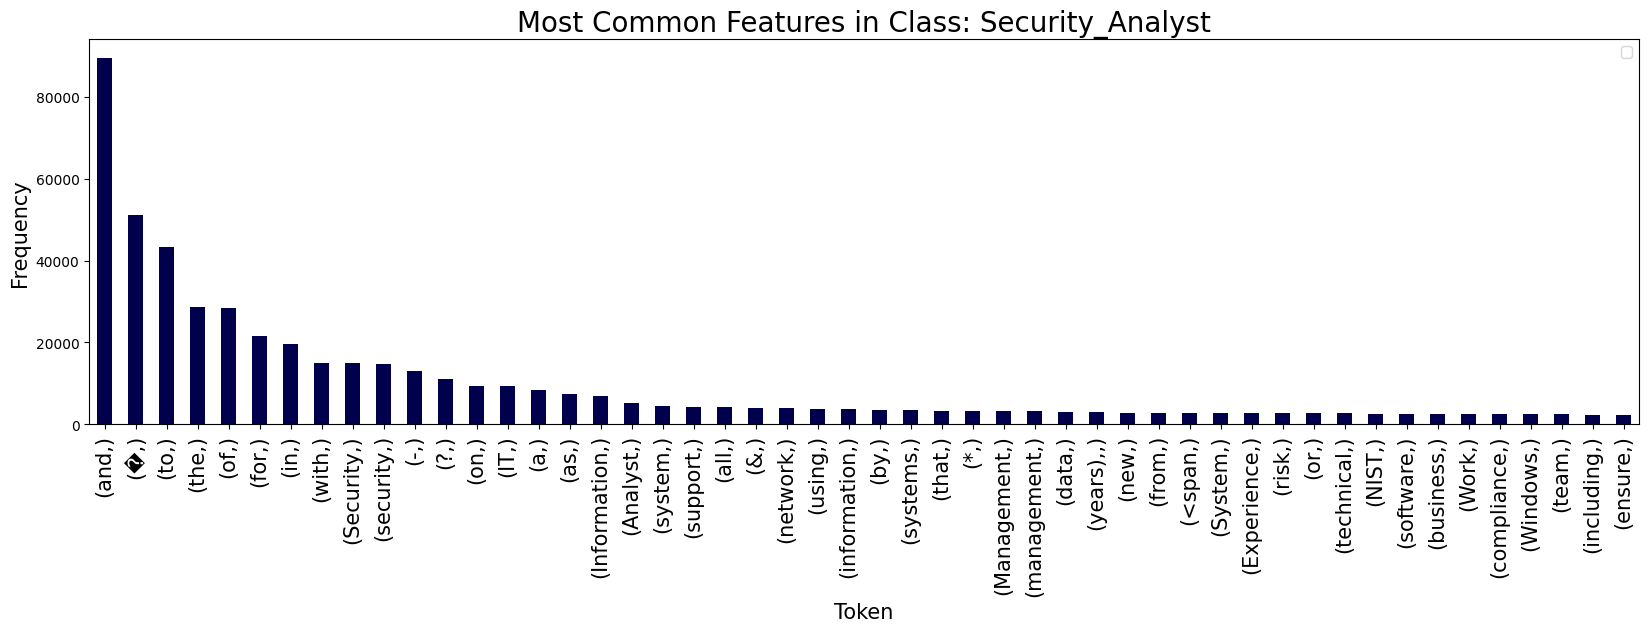

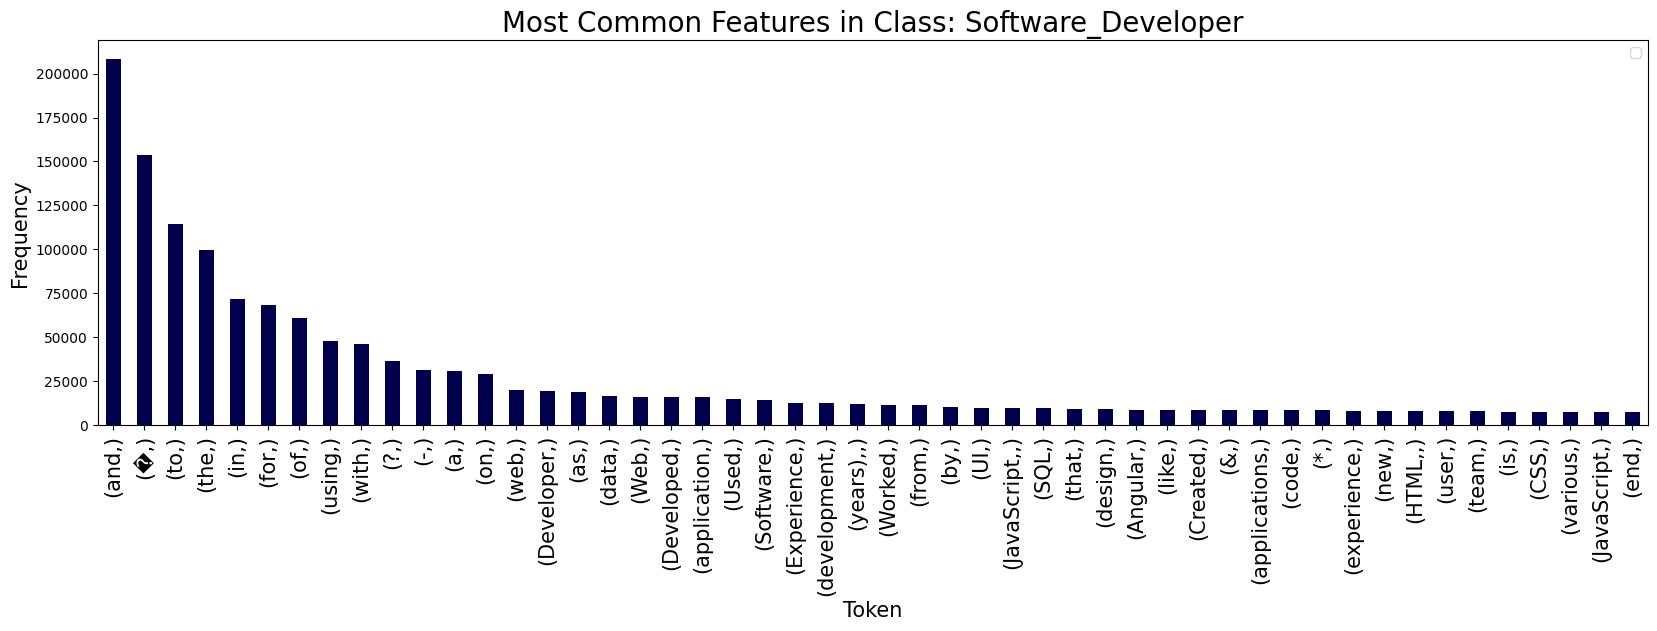

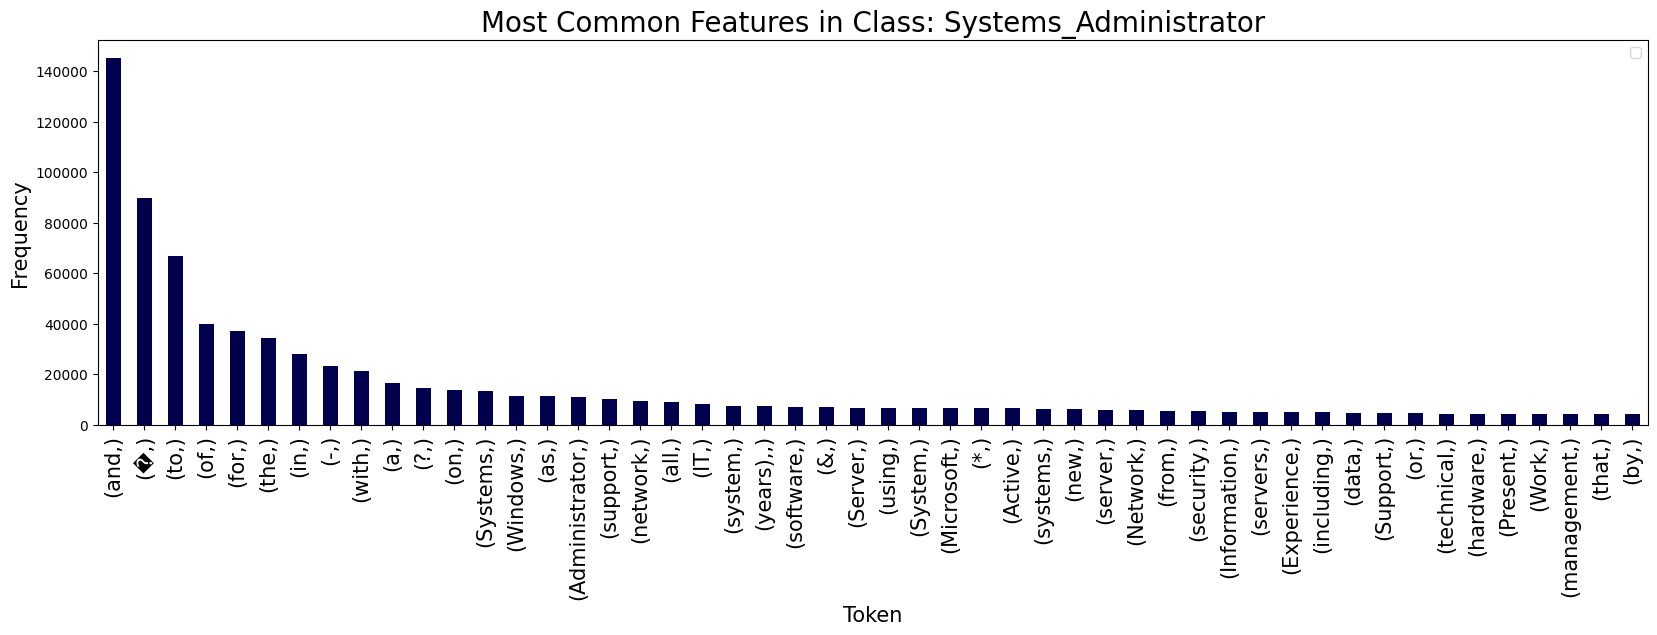

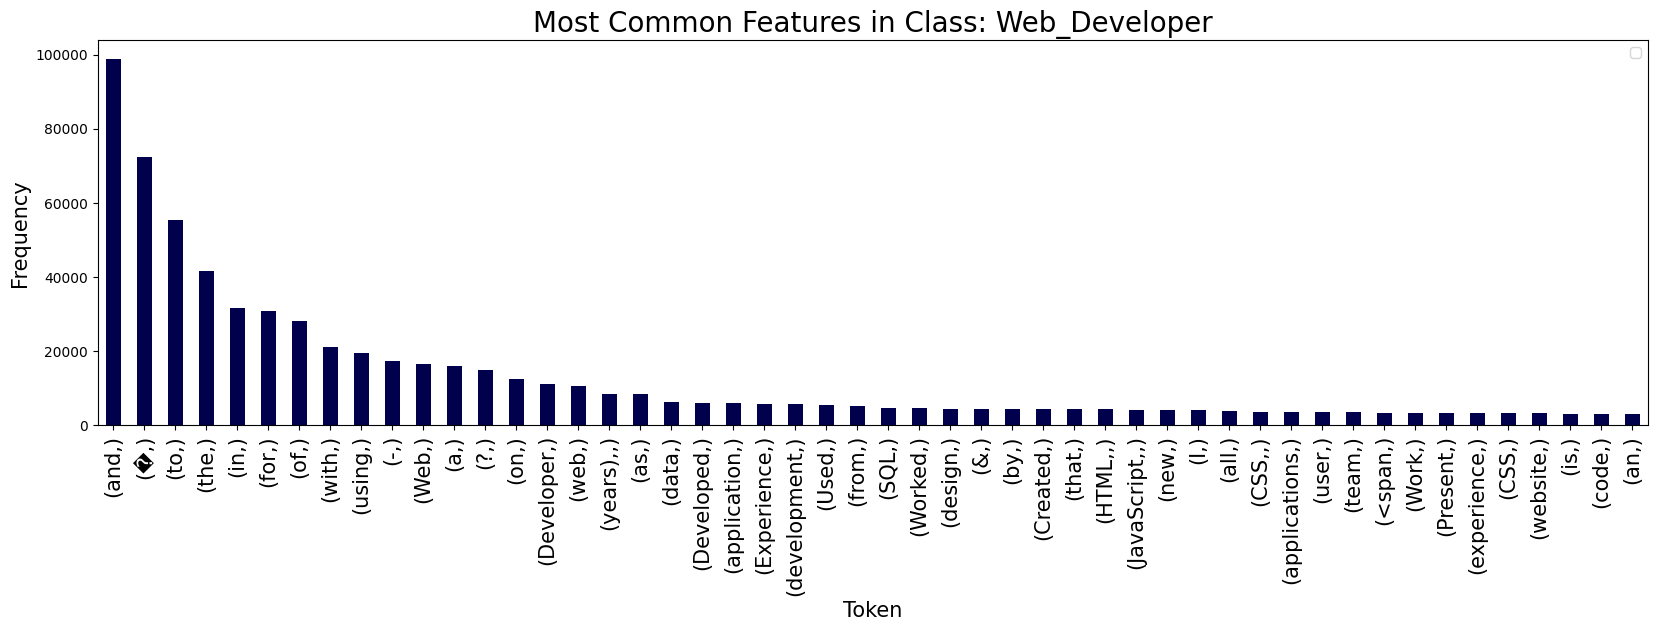

In [11]:
plot_most_common_features(training_df['Resume'], training_df['Label'])

Most of these are stopwords that are not related to the class and could negatively impact the final classifier. However, we won't need to preprocess the text because we are using BERT, which has its own mechanisms for handling such issues. BERT's tokenizer and model are designed to understand context and relationships between words, allowing it to manage stopwords, capitalization, and different verb forms effectively without extensive preprocessing. This should help in providing more accurate and representative results for our classification tasks.

### Checking for real keywords for each position
For explanatory reasons, we will preprocess our text data for showing some insights related to each kind of position. Most of the time, the most common keywords in each curriculum are the ones used by the **ATS** system.
We will:

 - Extract English Words
 - Stem words to avoid over counting same meaning words
 - Removing stop words

We will join training and test datasets to check for these insights. Recall that we will not use a preprocessed dataset for our model.

In [ ]:
dataset = pd.concat([training_df,test_df], sort=True)

We will use the function `process_text` which encloses all the text processing

In [ ]:
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')

def process_text(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    not_stop_words = [w for w in words if not w in stops]
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    return( " ".join( stemmed ))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset['cleaned_Resume'] = dataset['Resume'].apply(lambda x: process_text(x))
dataset.head()

,Label,Resume,cleaned_Resume
20348,Software_Developer,"Expert Software developer Expert <span class=""...",expert softwar develop expert span class hl so...
26276,Java_Developer,"Java Developer <span class=""hl"">Java</span> <s...",java develop span class hl java span span clas...
22849,Database_Administrator,"Database Administrator <span class=""hl"">Databa...",databas administr span class hl databas span s...
1365,Web_Developer,"Front- End Web Developer <span class=""hl"">Fron...",front end web develop span class hl front span...
19938,Python_Developer,Machine Learning Engineer Machine Learning Eng...,machin learn engin machin learn engin machin l...


## Data Visualization of the most common keywords for each position

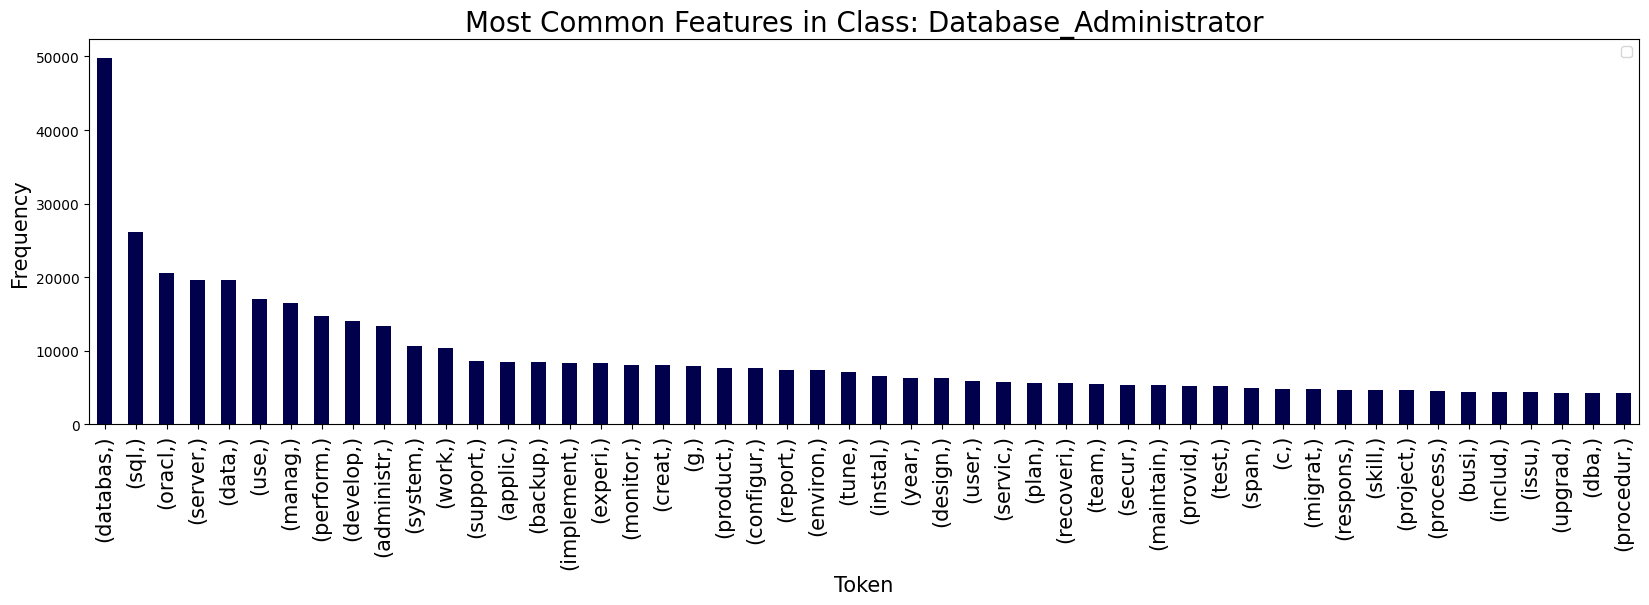

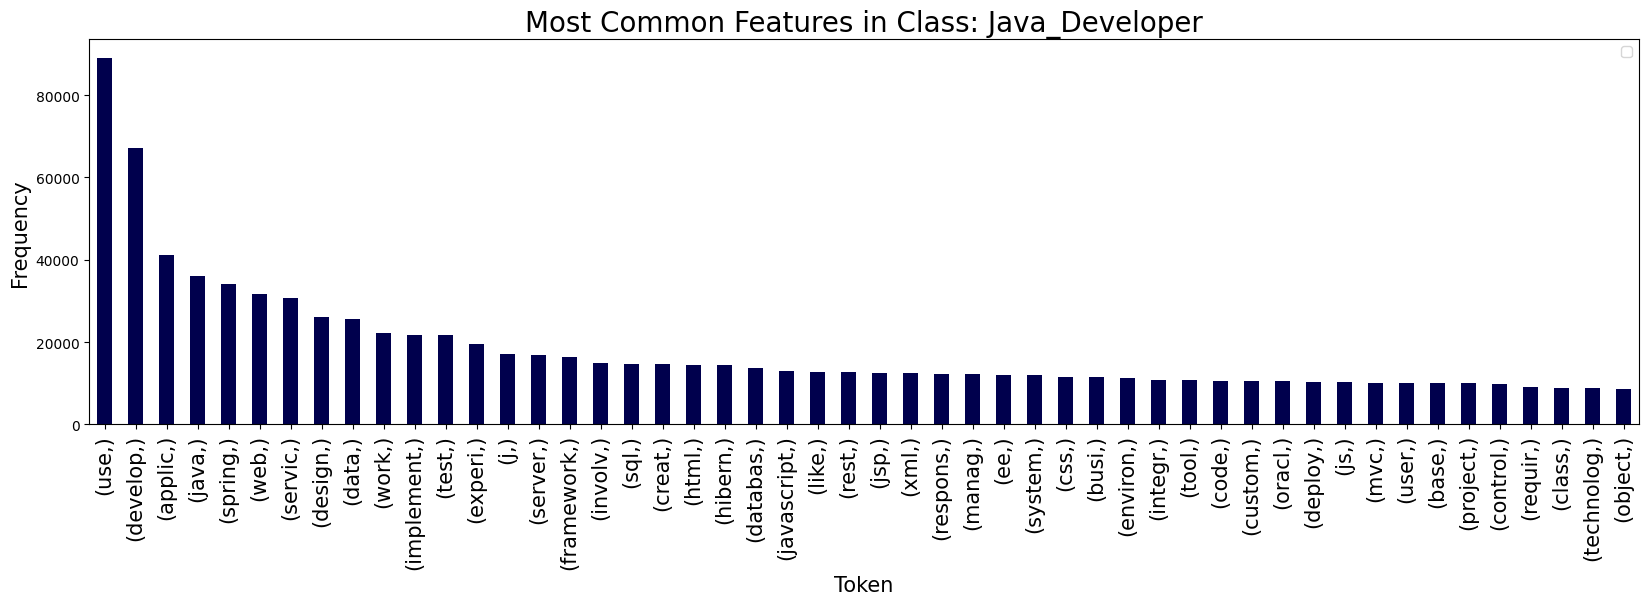

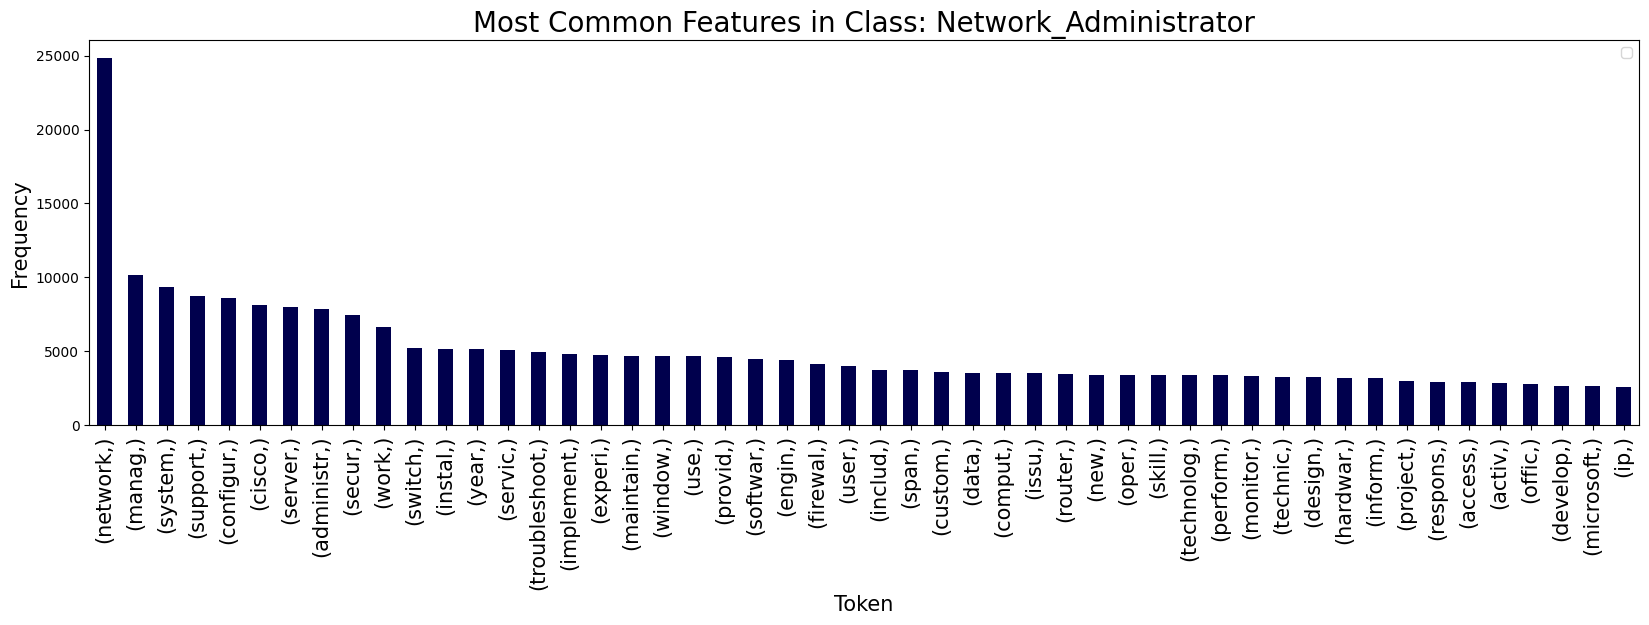

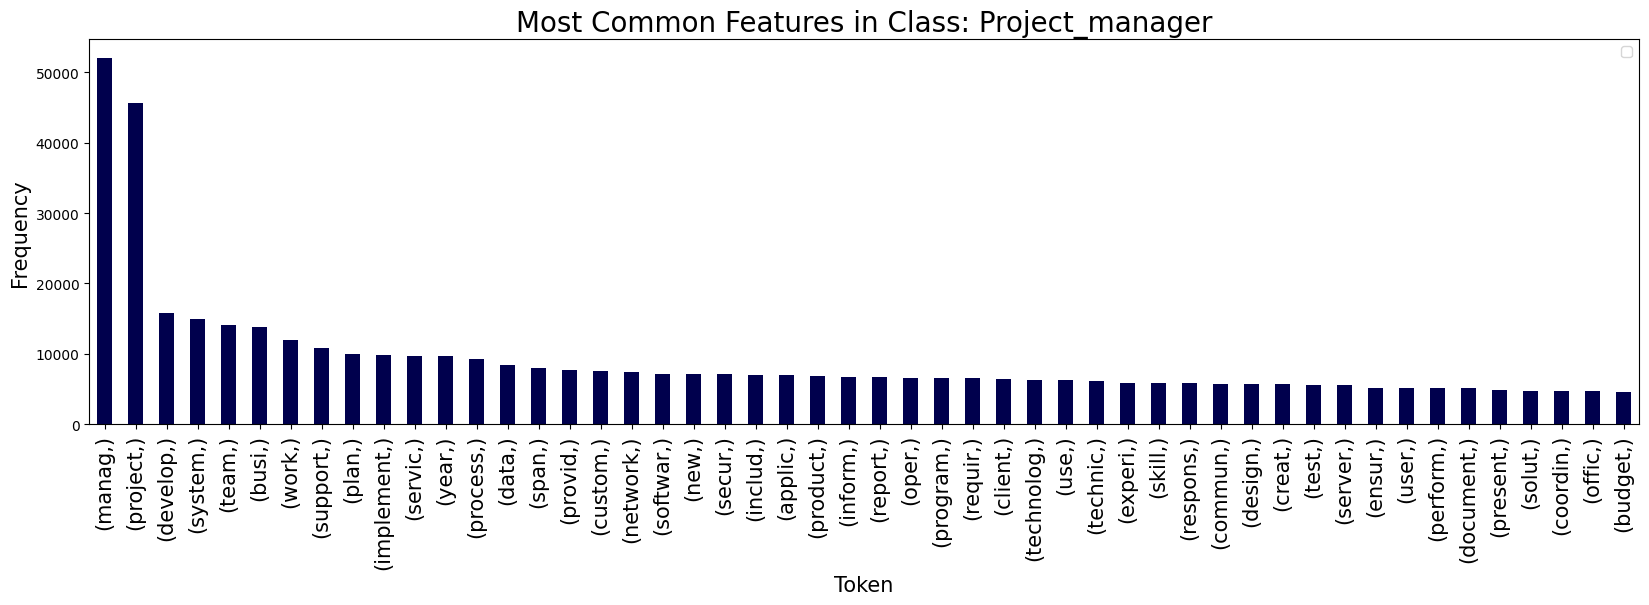

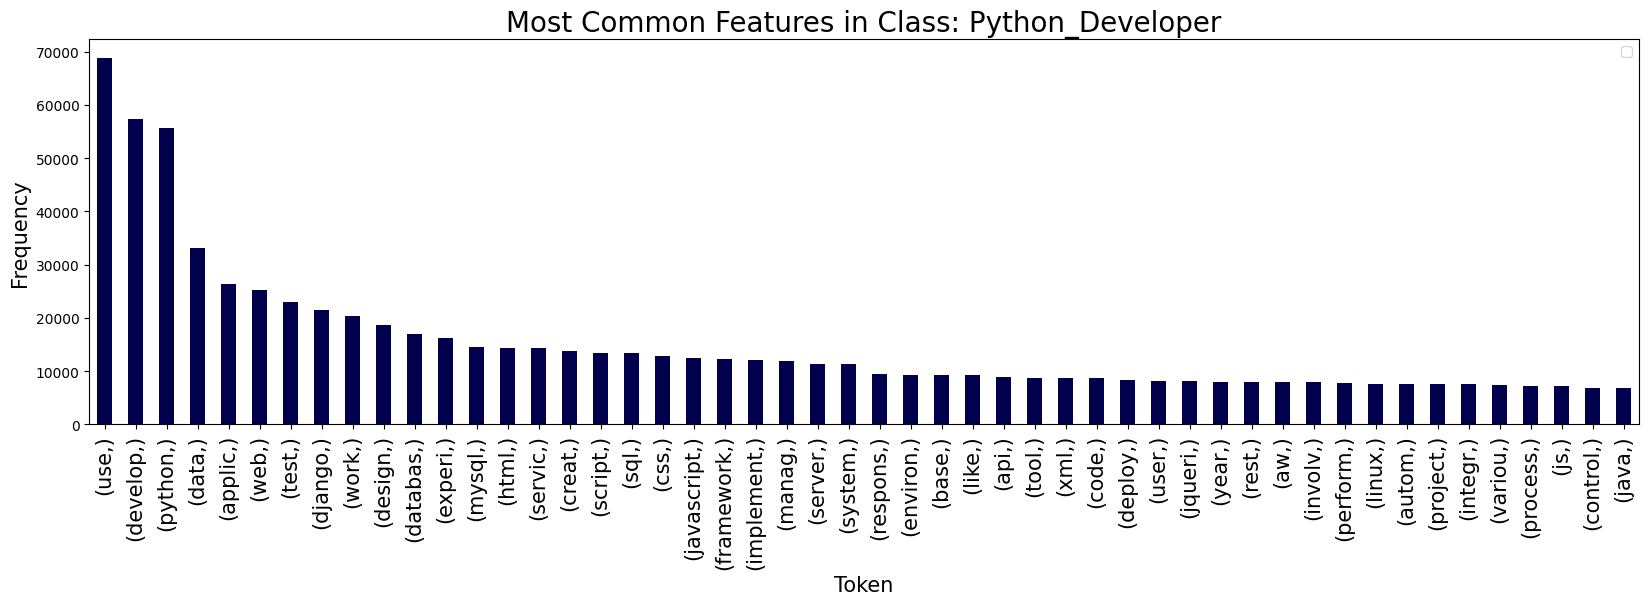

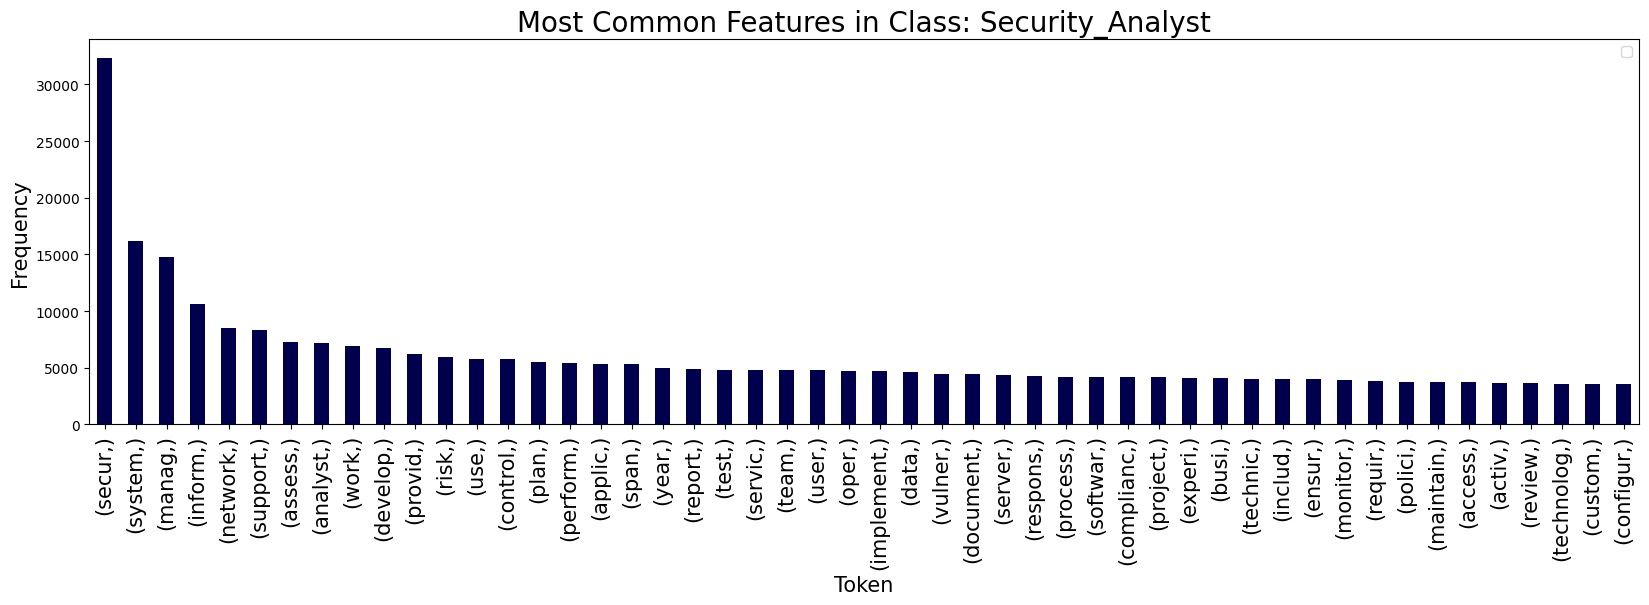

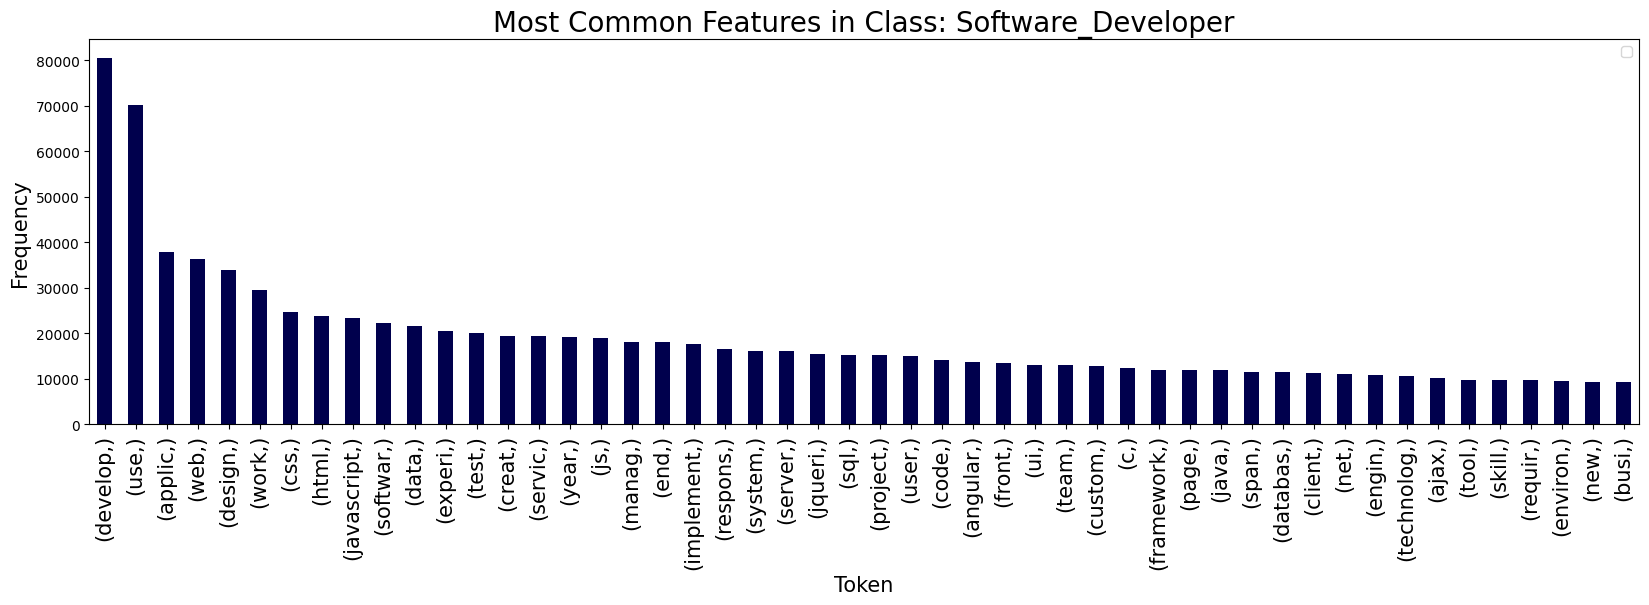

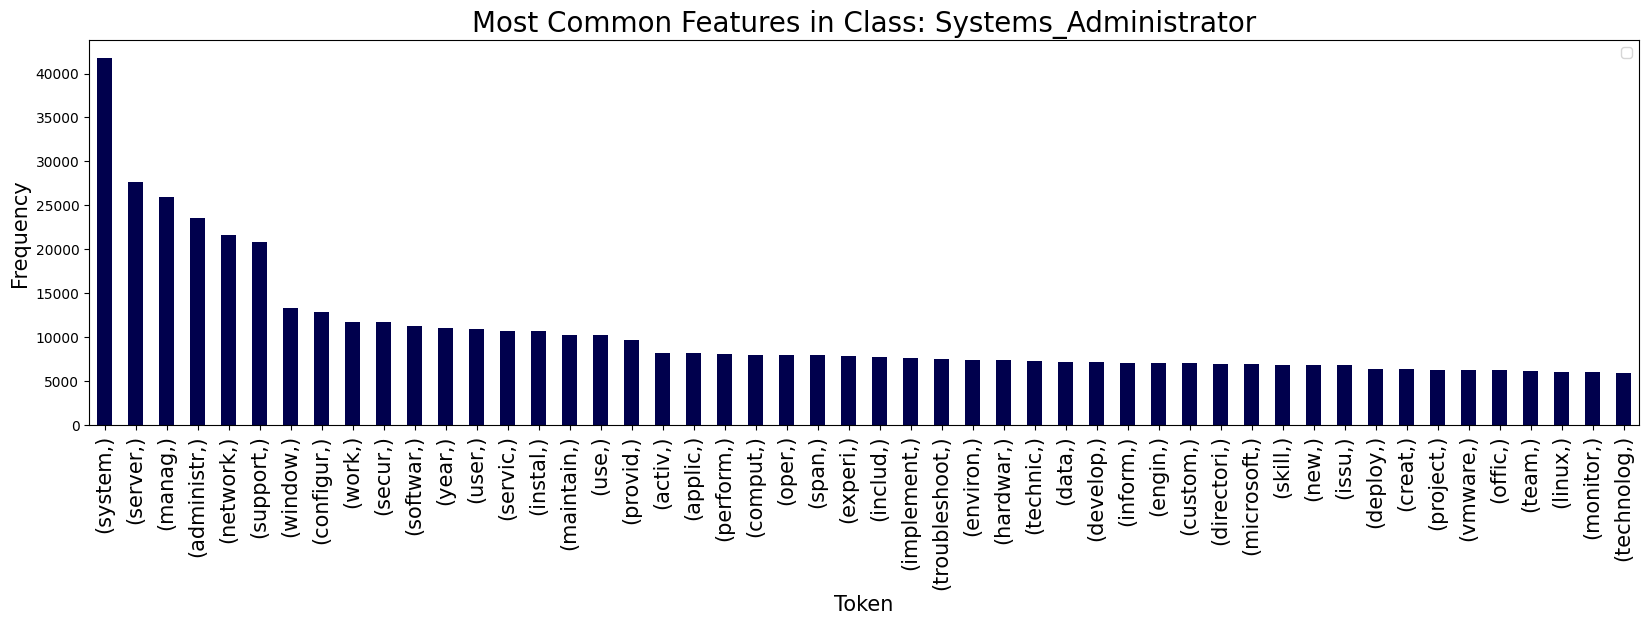

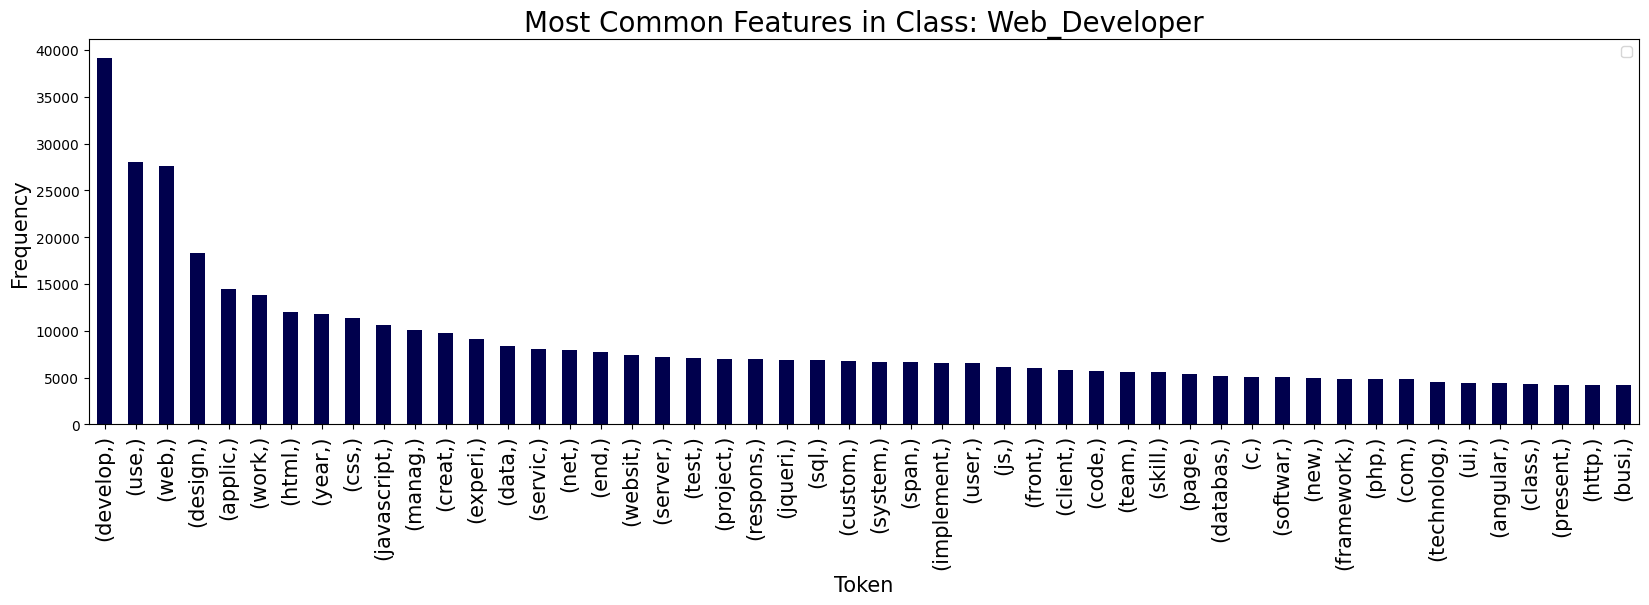

In [ ]:
plot_most_common_features(dataset['cleaned_Resume'], dataset['Label'])

It looks like the result is aligned with the position. Currently we are only observing what seems to be pertinent terms among the most frequent ones.

# STEP 4: Bert

Since it appears that Transformer-based models are beginning to surpass RNN-based systems. We'll now investigate how this applies to our specific problem. We will first load the necessary libraries.

In [13]:
!pip install ktrain -q
import tensorflow as tf
import ktrain
from ktrain import text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Creating the Transformer model
We'll begin by utilizing a Language Model pretrained on a large dataset—an English-speaking model, specifically BERT. As we know, BERT operates on the principle of **Self-Attention**, which differs from traditional RNN architectures by effectively learning sequential information from textual data.

Next, we need to **fine-tune** this model: retrain it according to our specific dataset and task. To elaborate, the BERT model includes an encoder block with pretrained weights, which gives BERT a broad understanding of English. The BERT encoder block analyzes each input CV comprehensively, generating an output that encapsulates the textual content's understanding. This representation is then fed into a text classifier.

In [14]:
trn, val, preproc = text.texts_from_df(training_df,'Resume',preprocess_mode='bert',label_columns='Label',verbose=True, maxlen=32) # Process the input tweets based on the BERT encoder
model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before
learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=128) # Creates the learning process to fine-tune bert and train the classifier.

['Database_Administrator', 'Java_Developer', 'Network_Administrator', 'Project_manager', 'Python_Developer', 'Security_Analyst', 'Software_Developer', 'Systems_Administrator', 'Web_Developer']
       Database_Administrator  Java_Developer  Network_Administrator  \
3293                      0.0             0.0                    0.0   
11389                     0.0             0.0                    0.0   
18064                     0.0             0.0                    0.0   
3060                      0.0             0.0                    0.0   
28439                     0.0             0.0                    0.0   

       Project_manager  Python_Developer  Security_Analyst  \
3293               0.0               1.0               0.0   
11389              0.0               0.0               0.0   
18064              0.0               0.0               0.0   
3060               0.0               0.0               0.0   
28439              0.0               0.0               0.0   

 

Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 32


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


## Training the model

Now we proceed to train the model, which involves both fine-tuning BERT and training the text classifier. BERT is known for its extensive size and high memory requirements, making it relatively slow during both the training phase and prediction phase. The first thing to do is to find the optimal learning rate.

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
164/164 [==============================] - 158s 816ms/step - loss: 1.5624 - accuracy: 0.4381
Epoch 2/2
164/164 [==============================] - 77s 467ms/step - loss: 21.2332 - accuracy: 0.1857


done.
Visually inspect loss plot and select learning rate associated with falling loss


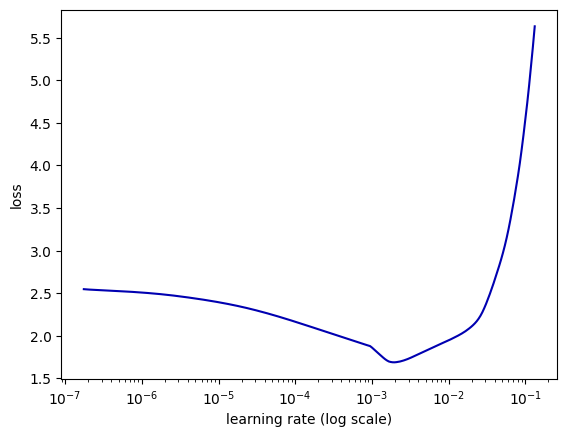

In [15]:
learner.lr_find(show_plot=True, max_epochs=2)

As we already understand, we aim for a learning rate that falls somewhere in the middle of the steepest slope of the loss function. For our specific case, this is approximately around 1e-4. We will proceed to train the model for a certain number of epochs and observe the results.

In [16]:
learner.autofit(lr=1e-4, # Learning Rate
                epochs=5, # Number of epochs to train the model
                early_stopping=2, # If the model does not improve after 2 epochs, we stop the training
                reduce_on_plateau=1,  # If the model does not improve aftear 1 epoch, we reduce the learning rate
                monitor='val_loss', # Metric to monitor the peformance of the model (loss computed on the validation dataset)
                checkpoint_folder='nlp_disaster/models/transformer_cpt_1' # After each epoch we store a checkpoint of the model
                )



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/5
164/164 [==============================] - 175s 948ms/step - loss: 0.7967 - accuracy: 0.7266 - val_loss: 0.5244 - val_accuracy: 0.8097
Epoch 2/5
164/164 [==============================] - 144s 879ms/step - loss: 0.4596 - accuracy: 0.8423 - val_loss: 0.5156 - val_accuracy: 0.8179
Epoch 3/5
164/164 [==============================] - 149s 907ms/step - loss: 0.3847 - accuracy: 0.8673 - val_loss: 0.5151 - val_accuracy: 0.8218
Epoch 4/5
164/164 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8954
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
164/164 [==============================] - 153s 933ms/step - loss: 0.2971 - accuracy: 0.8954 - val_loss: 0.5500 - val_accuracy: 0.8136
Epoch 5/5
164/164 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9413
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (

In [17]:
learner.save_model('/NLP') # Saving the trained model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We are going to now unfreeze the whole model to allow its retraining.

In [18]:
learner.unfreeze()
learner.fit_onecycle(1e-4/10, 1, checkpoint_folder='/NLP')



begin training using onecycle policy with max lr of 1e-05...
164/164 [==============================] - 178s 963ms/step - loss: 0.2580 - accuracy: 0.9167 - val_loss: 0.5444 - val_accuracy: 0.8205


In [19]:
learner.save_model('/NLP') # Store the final model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# STEP 5: Evaluate and Inspect the Model

We will show the confusion matrix in order to have some metrics and check the performance of the model

In [20]:
learner.validate(class_names=['Web_Developer', 'Project_manager', 'Software_Developer',
       'Database_Administrator', 'Python_Developer',
       'Systems_Administrator', 'Network_Administrator',
       'Security_Analyst', 'Java_Developer'])

73/73 [==============================] - 10s 71ms/step
                        precision    recall  f1-score   support

         Web_Developer       0.83      0.80      0.82       251
       Project_manager       0.87      0.88      0.87       196
    Software_Developer       0.75      0.74      0.75       187
Database_Administrator       0.84      0.79      0.81       279
      Python_Developer       0.89      0.87      0.88       187
 Systems_Administrator       0.86      0.83      0.85       184
 Network_Administrator       0.81      0.82      0.82       489
      Security_Analyst       0.80      0.87      0.83       306
        Java_Developer       0.77      0.77      0.77       244

              accuracy                           0.82      2323
             macro avg       0.82      0.82      0.82      2323
          weighted avg       0.82      0.82      0.82      2323



array([[202,   1,   8,  14,   2,   0,  10,  10,   4],
       [  2, 172,   0,   1,   1,   0,  14,   2,   4],
       [  4,   1, 139,   3,   0,   6,   4,  27,   3],
       [ 13,   2,   6, 220,   3,   9,   6,  11,   9],
       [  2,   3,   1,   2, 163,   0,  13,   2,   1],
       [  5,   0,   4,   8,   0, 153,   2,   8,   4],
       [  9,  16,   3,   7,  11,   4, 403,   6,  30],
       [  4,   0,  20,   5,   0,   6,   6, 265,   0],
       [  2,   3,   4,   3,   3,   0,  38,   2, 189]])

The model is a little bit better on detecting Project_manager CV, maybe because it is the one less technical.
Overall, it shows a high accuracy of 84% meaning that our model is able to capture the information and classify it.


## Check model bad performance

We can also check where the model has failed in classifying

In [21]:
learner.view_top_losses(n=10, preproc=preproc)

73/73 [==============================] - 5s 72ms/step
----------
id:123 | loss:8.23 | true:Java_Developer | pred:Software_Developer)

[CLS] sr . ui / u ##x architect sr . ui / u ##x architect sr . ui / u ##x architect - first data belle ##ville , nj seasoned web [SEP]
----------
id:856 | loss:8.15 | true:Web_Developer | pred:Systems_Administrator)

[CLS] chief technology officer chief technology officer systems & network administration ( dev ##ops ) new york , ny proven technical professional with years of experience for positions in systems and [SEP]
----------
id:994 | loss:8.03 | true:Database_Administrator | pred:Project_manager)

[CLS] manager , application & infrastructure ( 2018 - present ) manager , application & amp ; infrastructure ( 2018 - present ) it manager cornish , nh over 25 years [SEP]
----------
id:175 | loss:7.85 | true:Software_Developer | pred:Database_Administrator)

[CLS] mon ##go ##db architect / sr . mon ##go ##db ad ##min / developer mon ##go ##db architect /

In [22]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1
!pip3 install -q https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip


  Preparing metadata (setup.py) ... done
     - 6.9 MB 17.9 MB/s 0:00:00
  Preparing metadata (setup.py) ... done


We can use the explain method from ktrain in order to check how the model works in depth.

In [23]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.explain(" [CLS] RYANAIR LABS, MADRID, SPAIN: Data Scientist – Internship (APR. 2024 - ONGOING): Utilized SQL for extracting metrics from Azure Cloud, engineered a machine learning scheduling model increasing efficiency by 10%, and conducted quantitative analysis using Python for predicting flight delays; BULL SRL, ROME, ITALY: Financial Consultant - Internship (JAN.2021 – JUN.2021): Raised 400,000€ by leading investor meetings; IE BUSINESS SCHOOL, MADRID, SPAIN: Master in Business Analytics and Big Data (SEP. 2023 – JUL.2024 (EXPECTED)): Awarded €4,000 scholarship, GPA 3.74/4, honors in data science courses, advanced AI courses, AWS Cloud Practitioner Certification (In progress); UNIVERSITY CARLOS III OF MADRID, MADRID, SPAIN: Master in Finance (SEP. 2022 – JUL. 2023): Thesis on GARCH models, GPA 8.3/10, led a risk management project; UNIVERSITY OF ROMA TOR VERGATA, ROME, ITALY: Bachelor of Science in Business Administration and Economics (SEP. 2019 – JUL. 2022): Thesis on ACE Method, GPA 28.62/30, Erasmus program; Conducted 4 exchange programs in Australia, USA, and France; Languages: Italian (Native), English (Fluent), Spanish (Fluent), French (Advanced); IT Skills: Python, SQL, MATLAB, R, Apache Spark, MySQL, MongoDB, Hadoop, Kafka, Looker Studio, Tableau, EViews, Pandas, Numpy, Scikit-learn, TensorFlow, Matplotlib, Keras, Seaborn, Streamlit, Dataiku, Gretl [SEP]")